In [1]:
pwd()

"/home/kyan/Projects/qgplsim"

# DGP

In [2]:
using DelimitedFiles, Distributions

In [132]:
student_t = StudentizedRange(2, 4)

StudentizedRange{Float64}(ν=2.0, k=4.0)

In [135]:
@time rand(student_t, 1000)
d2 = Cauchy(0,1)
@time rand(d2, 1000)
@time randn(1000)
d2

  6.712398 seconds (1 allocation: 7.938 KiB)
  0.000038 seconds (1 allocation: 7.938 KiB)
  0.000011 seconds (1 allocation: 7.938 KiB)


Cauchy{Float64}(μ=0.0, σ=1.0)

In [11]:
ϵt = rand(student_t, 10000)
filename = "studentized.txt"
open(filename, "a") do io
    writedlm(io, ϵt)
end

In [14]:
et = readdlm(filename, Float64)
size(et)

(12000, 1)

# QGPLSIM fitting

In [4]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("qgplsim.ji")
using Statistics, LinearAlgebra, Clustering

In [5]:
α = [-1.0, 1.0, -0.5, 4.0, 2.0] # single index for x, α[1] = c0
θ = [ 0.0, 1.0, 2.0, 1.0./2.0, -1.0]  # linear for x, <α, θ> = 0 for identification, θ[1] = c1 := 0
γ = [0.5, 1.0, -0.5]  * 1.0 # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5, -0.5] * 1.0

# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n_ = 250
n0 = 500
n1 = 750
n2 = 1000
n3 = 1500
n4 = 2000
n5 = 3000
n6 = 4000
n7 = 6000
n8 = 8000
n9 = 12000
n = n2

fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 0 # 0 for gauss, 1 for t
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5
widthExp = -0.17
intercept = 0
# Estimation 

model1 = qgplsim.model(X, Z, y, τ, widthExp, intercept)
alpha_type = 1

# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for estimated  ̂α

@time alpha, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)

println("Estimation of index coefs: ")
println("̂α => ", alpha)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

 15.314882 seconds (52.69 M allocations: 11.701 GiB, 9.92% gc time, 72.15% compilation time)
Estimation of index coefs: 
̂α => [0.20058427667495188, -0.06492374439669507, 0.876290478176297, 0.43320417036526265]
̂γ => [0.33340300715807586, 0.2600258072894054, 0.1044214899386383]
Estimation of linear coefs: 
̂θ => [1.0003780933431845; 1.8920035159622672; 0.41341044930451043; -1.0158992779773672]
̂β => [0.6453072267873656, -0.42707004343030713, -0.12225214753961679]


In [6]:
model1.alpha

4-element Vector{Float64}:
  0.20058427667495188
 -0.06492374439669507
  0.876290478176297
  0.43320417036526265

In [7]:
alpha ./ alpha[1] |> transpose

1×4 transpose(::Vector{Float64}) with eltype Float64:
 1.0  -0.323673  4.36869  2.15971

In [8]:
norm(α)

4.716990566028302

In [9]:
gamma * norm(α) * 0.8

3-element Vector{Float64}:
 1.2581270715600883
 0.9812314239264147
 0.3940441463449409

# Quantreg and GLM fitting

In [2]:
using DataFrames, QuantReg, GLM

In [3]:
dft = DataFrame([X y])

formula = Term(:x5) ~ sum([Term(x) for x in [:x1, :x2, :x3, :x4]])

qmodel = QuantRegModel(formula, dft)
QuantReg.fit(qmodel)


x5 ~ 1 + x1 + x2 + x3 + x4, τ=0.5


Degrees of freedom: 1000 total; 995 residual

────────────────────────
             Coefficient
────────────────────────
(Intercept)     1.0866
x1              2.27964
x2              1.53174
x3              1.557
x4              0.411786
────────────────────────

In [4]:
lm(formula, dft)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

x5 ~ 1 + x1 + x2 + x3 + x4

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  1.21613    0.0211369   57.54    <1e-99   1.17465    1.25761
x1           2.28726    0.0210964  108.42    <1e-99   2.24586    2.32866
x2           1.50463    0.0220314   68.29    <1e-99   1.4614     1.54786
x3           1.52847    0.0214012   71.42    <1e-99   1.48648    1.57047
x4           0.438439   0.0205898   21.29    <1e-82   0.398035   0.478843
─────────────────────────────────────────────────────────────────────────

# QGPLSIM prediction

In [10]:
using Plots

In [15]:
a = α[2:end]
a = a/norm(a)

4-element Vector{Float64}:
  0.21693045781865616
 -0.10846522890932808
  0.8677218312746247
  0.4338609156373123

In [12]:
X, Z, y = dgp(2000, γ, θ, α, β, fx, dist, ifz, 1.6)
v = X*a
model1 = qgplsim.model(X, Z, y, 0.5)
qgplsim.estimator(model1)
v1 = X * model1.alpha
yp1 = qgplsim.predict(model1, X, Z, 0)

model2 = qgplsim.model(X, Z, y, 0.1)
qgplsim.estimator(model2)
v2 = X * model2.alpha
yp2 = qgplsim.predict(model2, X, Z, 0)

model3 = qgplsim.model(X, Z, y, 0.9)
qgplsim.estimator(model3)
v3 = X * model3.alpha
yp3 = qgplsim.predict(model3, X, Z, 0)

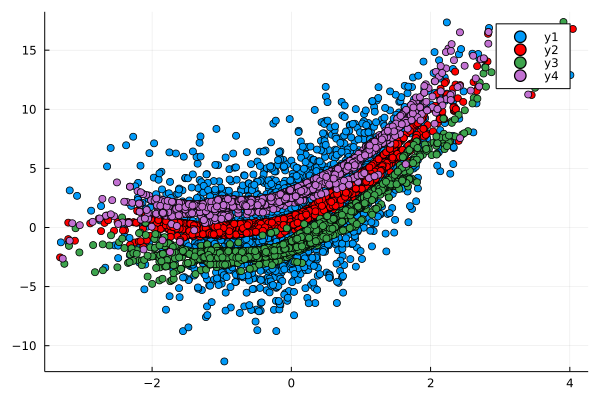

In [16]:
scatter(v, y)
scatter!(v1, yp1, color = "red")
scatter!(v2, yp2)
scatter!(v3, yp3)

## Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

width = 0.6716841133374799
dy = 0.2815371851442344
dx = 0.9620415295823663


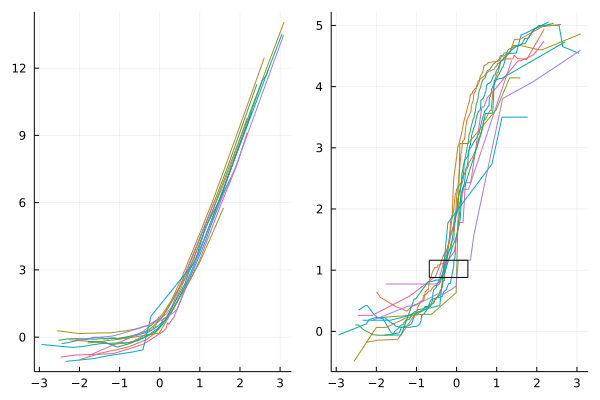

In [105]:
g = zeros(n)
dg = zeros(n)
yz = y - X * theta


X = [ones(n, intercept) X]
v = X * alpha
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h # + h
    vkmax = maximum(vk) - h# - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println("width = ", mean(width))
# v0, v1 = v0 + h, v1 - h
# v0, v1

v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = false ) # L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false ) # L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
println("dy = ", c1 - c0)
println("dx = ", v1 - v0)

plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [214]:
Threads.nthreads()

2

In [19]:
include("MonteCarloSIM.ji")

α = [-1.0, 1.0, -3.0] # single index for x
θ = [0.0, 3.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0]  # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] 
widthExp = -0.17
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 500
fx = 2
dist = 0 # 1 for t
intercept = 0
rep = 100 # MC rept. times

100

# Monte Carlo Simulation

In [20]:
@time Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, 0.5, fx, dist, widthExp, intercept, rep)

mb1 = mean(Beta, dims = 1)

mt1 = mean(Theta, dims = 1)

ma1 = mean(Alpha, dims = 1)

mg1 = mean(Gamma, dims = 1) 

 50.054629 seconds (478.15 M allocations: 195.403 GiB, 25.74% gc time, 2.51% compilation time)


1×2 Matrix{Float64}:
 0.387341  0.776403

In [248]:
var1 = var(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.0203873  0.0103886

In [10]:
mt1

1×2 Matrix{Float64}:
 1.02292  1.98037

In [8]:
ma1

1×2 Matrix{Float64}:
 0.886613  -0.456838

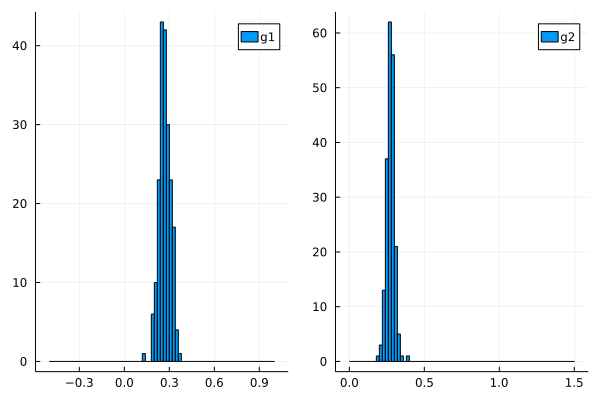

In [159]:
p1 = histogram(Gamma[:,1], bins = -0.5:0.02:1, label = "g1")
p2 = histogram(Gamma[:,2], bins = 0:0.02:1.5, label = "g2")
plot(p1, p2, layout = (1, 2))

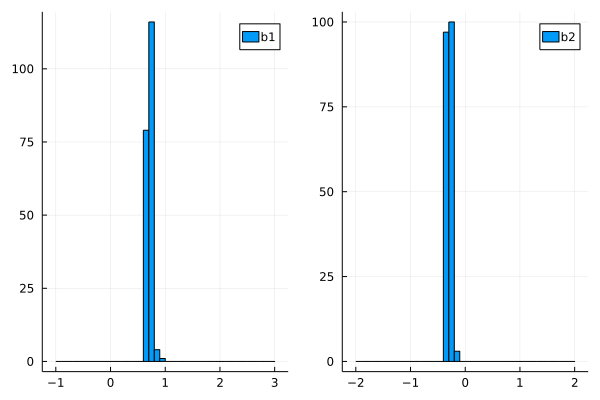

In [147]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

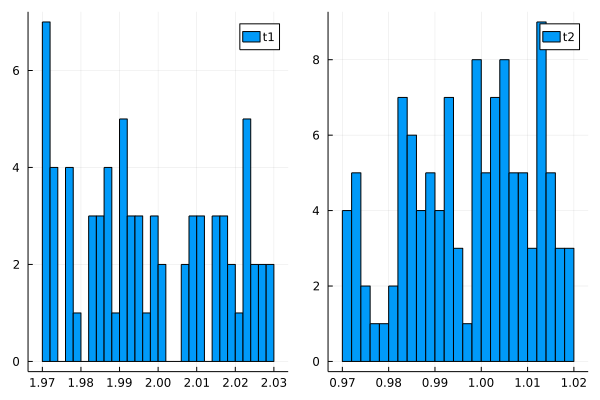

In [14]:
p1 = histogram(Theta[:,1], bins = 1.97:0.002:2.03, label = "t1")
p2 = histogram(Theta[:,2], bins = 0.97:0.002:1.02, label = "t2")
plot(p1, p2, layout = (1, 2))

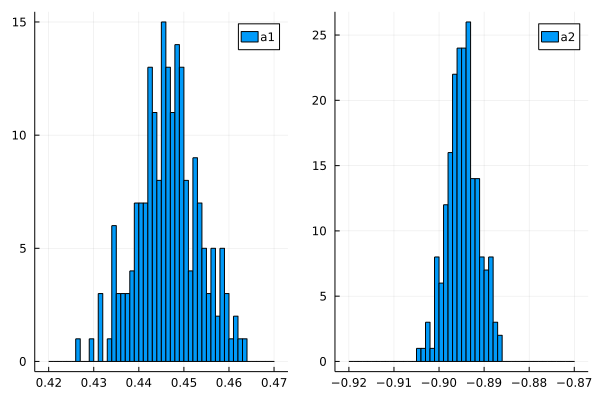

In [16]:
p1 = histogram(Alpha[:,1], bins = 0.42:0.001:0.47, label = "a1")
p2 = histogram(Alpha[:,2], bins = -0.92:0.001:-0.87, label = "a2")
plot(p1, p2, layout = (1, 2))

# Postprocess

In [82]:
α = [-1.0, 1.0, -0.5, 4.0, 2.0] # single index for x
# lenα = norm(α)
θ = [0.0, 1.0, 2.0, 0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
# γ = [1.0, 0.5] # single index for z
β2 = [0.5, -0.5] # linear for z
β3 = [0.5, -0.5, -0.5] # linear for z
Γ2 = [[0.5, 0.001], [0.5, 1.0], [0.001, 0.5], [1.0, 0.5], [0.5, 0.5]] 
Γ3 = [[0.001, 0.001, 0.001], [0.001, 0.5, 0.5], [0.001, 0.5, 1.0], [0.5, 0.5, 0.5], [0.5, 1.0, 2.0]] 
include("postprocess.ji")

mean_var (generic function with 4 methods)

In [166]:
N = [500, 1000] # 500 or 1000
F = [1, 2] # 1 or 2
D = [0, 1, 2]
set = []
     for f in F
        for d in D
            for n in N
                s = [n, f, d]
                push!(set, s)
            end
        end
    end
set

12-element Vector{Any}:
 [500, 1, 0]
 [1000, 1, 0]
 [500, 1, 1]
 [1000, 1, 1]
 [500, 1, 2]
 [1000, 1, 2]
 [500, 2, 0]
 [1000, 2, 0]
 [500, 2, 1]
 [1000, 2, 1]
 [500, 2, 2]
 [1000, 2, 2]

In [167]:
index_a = 1:4
index_g = 5:6
index_t = 7:10
lena = norm(α)

4.716990566028302

In [180]:
gk = 2
γ = Γ2[gk] 

for s in set
    agbt = read_agbt(s[1],s[2],s[3],gk)
    Gamma = agbt[:, index_g] * lena * 0.83
    mse_g = mse(Gamma, γ)
    mmg = round(mean(mse_g), digits=4) |> string
    vmg = round(var(mse_g) |> sqrt, digits=4) |> string
    if length(mmg) < 6
        mmg = string(mmg, "0")
    end
    if length(vmg) < 6
        vmg = string(vmg, "0")
    end
    println(s)
    println(mmg, '(', vmg, ')')
    println(mean(Gamma, dims = 1))
end

[500, 1, 0]
0.0875(0.0942)
[0.5026872756508528 1.0235561977761352]
[1000, 1, 0]
0.0242(0.0229)
[0.5004959730316867 0.9967274046273953]
[500, 1, 1]
0.080(0.0846)
[0.5210334967728248 1.0345429813196712]
[1000, 1, 1]
0.0223(0.0231)
[0.48883521337521607 0.995693883050984]
[500, 1, 2]
0.0934(0.1992)
[0.47742127067134166 1.0140451926236302]
[1000, 1, 2]
0.1207(0.8293)
[0.5064825206849654 0.9943832807120656]
[500, 2, 0]
0.1506(0.1541)
[0.4944662900232858 1.0671718279558002]
[1000, 2, 0]
0.0598(0.0622)
[0.5129955535914017 1.0078699430038045]
[500, 2, 1]
0.2485(0.6406)
[0.566783667926387 1.0289646236420187]
[1000, 2, 1]
0.0803(0.1654)
[0.4830015120266385 1.0187831419999451]
[500, 2, 2]
2.0608(5.7779)
[0.4504190434144224 0.8532701176438314]
[1000, 2, 2]
0.8821(3.2766)
[0.44198206365112924 0.9399221919508469]


In [137]:
agbt = read_agbt(500,2,2,1)
mean(agbt, dims=1)

1×12 Matrix{Float64}:
 0.235541  -0.0631896  0.618301  0.316388  …  -0.838207  0.515621  -0.63708

In [61]:
var(mse_g)

0.22279491171614488

In [76]:
mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.45832  0.990662

In [41]:
Alpha = agbt2[:, 1:4] * lena
mean(Alpha, dims = 1)

1×4 Matrix{Float64}:
 0.993321  -0.450712  3.98013  2.02877

In [48]:
mse(Alpha, α[2:end], 100)

1.1065700508932266

In [46]:
α

5-element Vector{Float64}:
 -1.0
  1.0
 -0.5
  4.0
  2.0